## Multilayer fully-connected network 

In [1]:
import tensorflow as tf

graph = tf.Graph()

with graph.as_default():
    X_placeholder = tf.placeholder(dtype=tf.float32, shape = [None, 4096])
    y_placeholder = tf.placeholder(dtype=tf.int32, shape=[None])
    
    hidden = tf.layers.dense(
        X_placeholder, 64, activation = tf.nn.relu,
        kernel_initializer = tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer = tf.zeros_initializer(),
        name = 'hidden'
    )
    
    
#Add dropout to the input and hidden units with a rate of 0.5
    training = tf.placeholder(dtype=tf.bool)
    
    hidden = tf.layers.dropout(
        hidden, rate=0.5, seed=0, training=training)
    
    logits = tf.layers.dense(
        hidden, 10, activation=None,
        kernel_initializer = tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer = tf.zeros_initializer(),
        name='output'
    )

#weights matrice W1 
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')

#Output matrice W2    
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')
               
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_placeholder, logits=logits))

    
# add L2  regularization term to the cross-entropy loss to penalize large values in the hidden and output 
# weight matrices W1, W2    
    
    l2_term = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
    alpha = tf.placeholder(dtype=tf.float32)
    loss = mean_ce + alpha * l2_term
    
    
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)
        
    
    train_op = gd.minimize(loss)
        
    predictions = tf.argmax(logits, axis =1, output_type=tf.int32)
    is_correct = tf.equal(y_placeholder, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    

In [2]:
#Split the 5000 labeled data points from cifar4-train.npz into train, validation and test sets 
# with respectively 3200, 800 and 1000 data points. 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

with np.load('cifar4-train.npz', allow_pickle = False) as npz_file:
    cifar4_data = dict(npz_file.items())
    
print(list(cifar4_data.keys()))


X = cifar4_data['overfeat']
y = cifar4_data['labels']

print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)


# Convert the type of the input matrix to float
X = X.astype(np.float)

# Split data into train/test sets keeping same proportion of classes
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=4000, test_size=1000, random_state=0, stratify=y)

print ('Train set:', X_tr.shape, y_tr.shape)
print('Test set:', X_te.shape, y_te.shape)


# Split train set into train/validation sets
X_tr_s, X_val, y_tr_s, y_val = train_test_split(X_tr, y_tr, train_size=3200, test_size=800, random_state=0, stratify=y_tr)

print('Small train set:', X_tr_s.shape, y_tr_s.shape)
print('Validation set:', X_val.shape, y_val.shape)


scaler = StandardScaler()
X_tr_s_rescaled = scaler.fit_transform(X_tr_s)
X_val_rescaled = scaler.transform(X_val)
X_te_rescaled = scaler.transform(X_te)

['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']
X: (5000, 4096) float32
y: (5000,) int64
Train set: (4000, 4096) (4000,)
Test set: (1000, 4096) (1000,)
Small train set: (3200, 4096) (3200,)
Validation set: (800, 4096) (800,)


In [3]:
#Train the network using small random batches of data from the train set, and save its accuracy on the validation set. 

#batch generator
def get_batches(X, y, batch_size):
    shuffled_idx = np.arange(len(y))
    np.random.shuffle(shuffled_idx)
        
    for i in range(0, len(y), batch_size):
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]
                 

In [4]:
#validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    np.random.seed(0)
    
    for epoch in range(150):
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_tr_s_rescaled, y_tr_s, 256):
            _, acc_value = sess.run([train_op, accuracy], feed_dict = {
                X_placeholder: X_batch,
                y_placeholder: y_batch,
                lr: 0.01,
                training: True,
                alpha: 0.1
            })
            
            batch_acc.append(acc_value)
        
        valid_acc = sess.run(accuracy, feed_dict = {
            X_placeholder: X_val_rescaled,
            y_placeholder: y_val,
            training: False
        })
        valid_acc_values.append(valid_acc)
        
        print('Epoch {} - valid: {:.3f} train: {:.3f}(mean)'.format(epoch+1, valid_acc, np.mean(batch_acc)
        ))
   
    #evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict = {
        X_placeholder: X_te_rescaled,
        y_placeholder: y_te,
        training: False
    })
        
    print('Test accuracy: {:.3f}'.format(test_acc))
        

Epoch 1 - valid: 0.689 train: 0.324(mean)
Epoch 2 - valid: 0.769 train: 0.627(mean)
Epoch 3 - valid: 0.784 train: 0.694(mean)
Epoch 4 - valid: 0.799 train: 0.737(mean)
Epoch 5 - valid: 0.803 train: 0.750(mean)
Epoch 6 - valid: 0.801 train: 0.769(mean)
Epoch 7 - valid: 0.810 train: 0.771(mean)
Epoch 8 - valid: 0.810 train: 0.790(mean)
Epoch 9 - valid: 0.819 train: 0.787(mean)
Epoch 10 - valid: 0.816 train: 0.792(mean)
Epoch 11 - valid: 0.812 train: 0.798(mean)
Epoch 12 - valid: 0.822 train: 0.801(mean)
Epoch 13 - valid: 0.824 train: 0.806(mean)
Epoch 14 - valid: 0.821 train: 0.811(mean)
Epoch 15 - valid: 0.827 train: 0.824(mean)
Epoch 16 - valid: 0.824 train: 0.828(mean)
Epoch 17 - valid: 0.829 train: 0.828(mean)
Epoch 18 - valid: 0.830 train: 0.821(mean)
Epoch 19 - valid: 0.829 train: 0.832(mean)
Epoch 20 - valid: 0.829 train: 0.828(mean)
Epoch 21 - valid: 0.830 train: 0.831(mean)
Epoch 22 - valid: 0.826 train: 0.829(mean)
Epoch 23 - valid: 0.831 train: 0.835(mean)
Epoch 24 - valid: 0.

After trying different values for the learning rate, reg strength, number of epoch, it seems that the last option is better 

In [5]:
print('Multilayer fully-connected network accuracy (test set): {:.3f}'.format(test_acc))

Multilayer fully-connected network accuracy (test set): 0.833


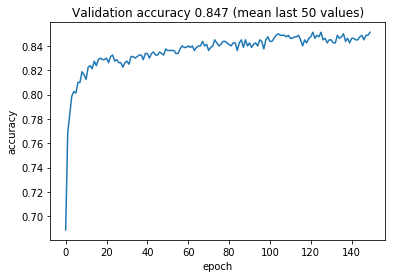

In [6]:
#Plot the results.

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 50 values)'.format(np.mean(valid_acc_values[-50:])))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
